# The LSST Cadence Impact on Non-Time-Critical Eclipsing Binary Science

Version 2023-05-23, by Andrej Prša (<aprsa@villanova.edu>)

This notebook recreates the results presented in [Prša, Yoachim and Jones (2023)](https://www.overleaf.com/read/djhcjfdjdrth): "The LSST Cadence Impact on Non-Time-Critical Eclipsing Binary Science". Please refer to the paper for all details on the computation logic.

## OpSim V2.1 baseline computation

We work out the simulation by using the opsim v2.1 baseline run; afterwards, we run the same steps on other opsim runs.

We start with the usual imports. OpSim runs are distributed as sqlite databases. We will use pickles to dump intermediate results that we reuse later on.

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import pickle
import os

For plotting, we generated a style file that makes the plots jupyter-friendlier. This is completely optional; if you decide to use it, you will need to copy [jupyter.mplstyle](https://github.com/aprsa/rubinEBs/blob/main/auxiliaries/jupyter.mplstyle) into `~/.config/matplotlib/stylelib/jupyter.mplstyle`.

In [2]:
plt.style.use('jupyter')

### Load opsim 2.1 data.

If you do not have it yet, you can grab the [baseline_v2.1_10yrs.db](http://astro-lsst-01.astro.washington.edu:8080/fbs_db/fbs_2.1/baseline/baseline_v2.1_10yrs.db) database (along with all other databases) from [here](http://astro-lsst-01.astro.washington.edu:8080/). Store it in subdirectory `subdir`, in our case `opsims`:

In [3]:
subdir = 'opsims'
opsim = 'baseline_v2.1'

db = sql.connect(f'{subdir}/{opsim}_10yrs.db')
dbc = db.cursor()

### Query all field right ascensions and declinations.

The idea is to look at their distributions and make sure that everything looks the way it should. We expect a smooth distribution that corresponds to the WFD and peaks that correspond to DDFs. We also expect to see a zone of avoidance in the direction of high galactic extinction.

In [4]:
dbc.execute('select fieldRa, fieldDec from observations')
results = dbc.fetchall()
r = np.array(results)
print(f'{r.shape[0]} field visits read in.')

2081749 field visits read in.


Thus, we have 2M+ visits in all $ugrizy$ passbands over the course of 10 years. Plot their distributions:

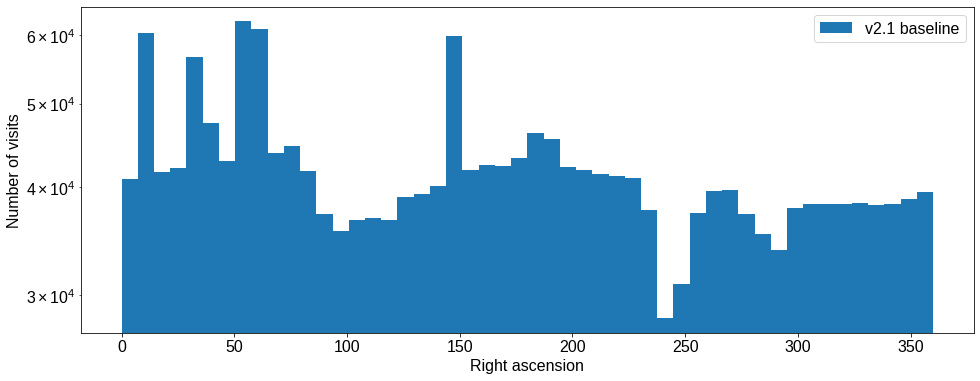

In [5]:
plt.yscale('log')
plt.xlabel('Right ascension')
plt.ylabel('Number of visits')
plt.hist(r[:,0], bins=50, label='v2.1 baseline')
plt.legend()
plt.savefig('figs/dist_ra.pdf')

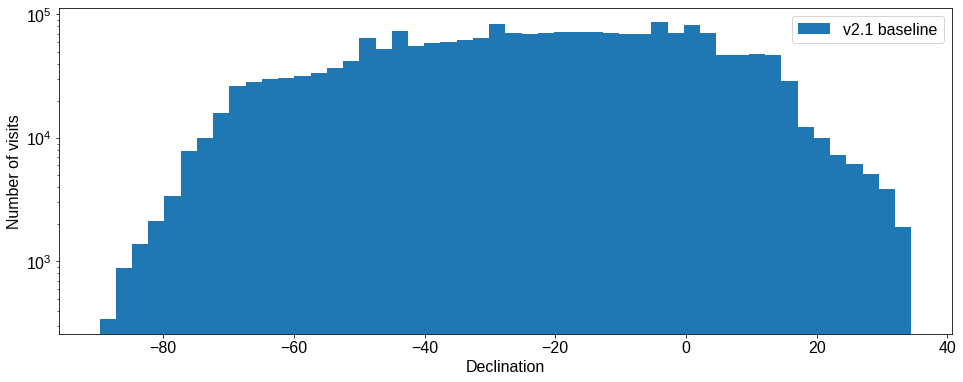

In [6]:
plt.yscale('log')
plt.xlabel('Declination')
plt.ylabel('Number of visits')
plt.hist(r[:,1], bins=50, label='v2.1 baseline')
plt.legend()
plt.savefig('figs/dist_dec.pdf')

These two plots reproduce Fig. 1 in the paper.

### Load the TESS EB catalog used for benchmarking.

You can extract the latest version from the [catalog homepage](http://tessEBs.villanova.edu) or grab the used catalog from [here](https://github.com/aprsa/rubinEBs/blob/main/auxiliaries/tessEBs.csv). We need spatial position, the ephemerides and eclipse parameters for all TESS EBs.

In [7]:
# tic=0, ra=5, dec=6, tmag=9, t0=10, P0=12, pf: pw=15, pd=16, pp=17, sw=18, sd=19, sp=20; 2g: pw=21, pd=22, pp=23, sw=24, sd=25, sp=26
tessEBs = np.genfromtxt('auxiliaries/tessEBs.csv', delimiter=',', usecols=(0, 10, 12, 5, 6, 15, 18, 21, 24, 17, 20), skip_header=True)
t0s = dict(zip(tessEBs[:,0], tessEBs[:,1]))
periods = dict(zip(tessEBs[:,0], tessEBs[:,2]))
pwidths_pf = dict(zip(tessEBs[:,0], tessEBs[:,5]))
swidths_pf = dict(zip(tessEBs[:,0], tessEBs[:,6]))
pwidths_2g = dict(zip(tessEBs[:,0], tessEBs[:,7]))
swidths_2g = dict(zip(tessEBs[:,0], tessEBs[:,8]))
ppos_pf = dict(zip(tessEBs[:,0], tessEBs[:,9]))
spos_pf = dict(zip(tessEBs[:,0], tessEBs[:,10]))

### For each EB in the TESS EB catalog, query the LSST field visits.

For each visit, record the timestamp and passband information. Store this information in a dictionary where TESS IDs are used as keys. **NOTE:** this is a computationally expensive step, so it is practical to have to do it only once. That is why, once the lookup is done, we pickle the timestamps and store them for future use. You can either recompute it here or use the pickle that is distributed and available [here](https://github.com/aprsa/rubinEBs/blob/main/timestamps/timestamps_baseline_v2.1.pkl).

In [8]:
if os.path.exists(f'timestamps/timestamps_{opsim}.pkl'):
    with open(f'timestamps/timestamps_{opsim}.pkl', 'rb') as f:
        eb_vro_obs = pickle.load(f)
else:
    eb_vro_obs = {}
    for i, eb in enumerate(tessEBs):
        print(f'TIC {int(eb[0])} processed ({i+1}/{len(tessEBs)}).')
        dbc.execute(f"select observationStartMJD,filter from observations where pow(fieldRa-({eb[3]}), 2) + pow(fieldDec-({eb[4]}), 2) < 3.0625")
        eb_vro_obs[int(eb[0])] = dbc.fetchall()

    with open(f'timestamps/timestamps_{opsim}.pkl', 'wb') as f:
        pickle.dump(eb_vro_obs, f)

Each entry in the timestamp has the timestamp itself and the filter in which the data were taken, for example:

In [9]:
list(eb_vro_obs.items())[0]

(91961,
 [(60365.268620232615, 'y'),
  (60365.29233825059, 'y'),
  (60365.300757273595, 'y'),
  (60365.32352518584, 'y'),
  (60374.25087474818, 'r'),
  (60374.274772042714, 'i'),
  (60374.28987802617, 'i'),
  (60374.31451248783, 'z'),
  (60377.39812844855, 'r'),
  (60382.3946814303, 'i'),
  (60383.390564578105, 'i'),
  (60383.39103179271, 'i'),
  (60383.400974161894, 'r'),
  (60383.40144005104, 'r'),
  (60386.40478158532, 'z'),
  (60391.36892813432, 'z'),
  (60391.3803152626, 'y'),
  (60395.382793404126, 'y'),
  (60395.39314022137, 'y'),
  (60402.359548948865, 'z'),
  (60402.37081936748, 'y'),
  (60403.23254585343, 'g'),
  (60403.25732356261, 'r'),
  (60404.35321428223, 'r'),
  (60404.37875005508, 'i'),
  (60408.18269169073, 'u'),
  (60408.206895174524, 'g'),
  (60409.316123681776, 'r'),
  (60409.34054914877, 'i'),
  (60411.310278588986, 'g'),
  (60411.33442371535, 'r'),
  (60415.30795405585, 'i'),
  (60415.33220003281, 'z'),
  (60421.16536730167, 'y'),
  (60421.1882415142, 'y'),
  (60

Now we can count the number of visits per passband. We will store the information in two dictionaries: `per_band_timestamps`, which holds timestamps divided by passbands, and `per_band_nobs`, which aggregates the number of observations rather than explicit timestamps. We also append another column to `per_band_nobs` for the cumulative number of observations.

In [10]:
passbands = ['u', 'g', 'r', 'i', 'z', 'y']
per_band_timestamps = {}
for tic, timestamps in eb_vro_obs.items():
    # skip any TESS EBs that LSST will not observe:
    if len(timestamps) == 0:
        continue
    per_band_timestamps[tic] = {}
    for passband in passbands:
        per_band_timestamps[tic][passband] = [ts[0] for ts in timestamps if ts[1] == passband]

per_band_nobs = np.empty((len(per_band_timestamps), 1+len(passbands)), dtype=int)
i = 0
for tic in eb_vro_obs.keys():
    if tic not in per_band_timestamps.keys():
        continue
    per_band_nobs[i,:-1] = [len(per_band_timestamps[tic][passband]) for passband in passbands]
    per_band_nobs[i, -1] = per_band_nobs[i,:-1].sum()
    i += 1

We can now easily plot per-passband visits:

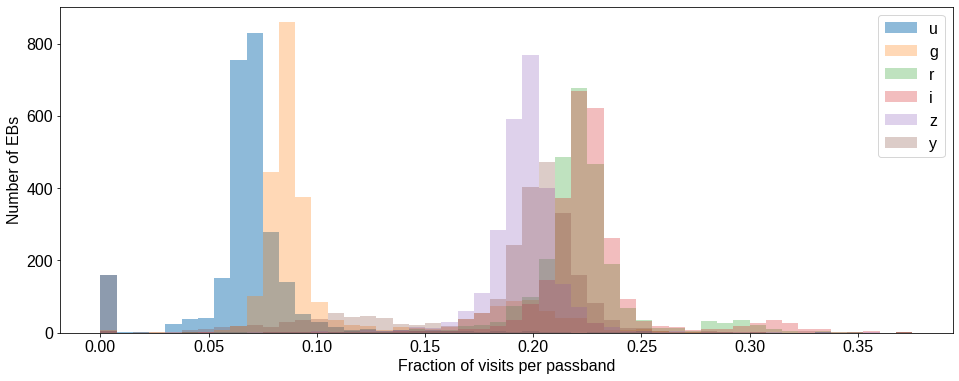

In [11]:
plt.xlabel('Fraction of visits per passband')
plt.ylabel('Number of EBs')

for i, passband in enumerate(passbands):
    if i == 0:
        v, r,_ = plt.hist(per_band_nobs[:,i]/per_band_nobs[:,-1], bins=50, alpha=0.5, label=passband)
    else:
        plt.hist(per_band_nobs[:,i]/per_band_nobs[:,-1], bins=r, alpha=0.3, label=passband)
        plt.legend()
plt.savefig(f'figures/per_passband_visits_{opsim}.pdf')

This recreates Fig. 6 from the paper. We will export `per_band_nobs` to disk, for opsim comparison purposes:

In [12]:
np.savetxt(f'colors/colors_{opsim}.csv', per_band_nobs, delimiter=',', fmt='%d')

We can now print out an aggregate count, which is reported in Table 3 of the paper:

In [13]:
for i, pb in enumerate(passbands):
    print(f'fraction in {pb}-band: {np.mean(per_band_nobs[:,i])/np.mean(per_band_nobs[:,-1]):0.3f} +/- {np.std(per_band_nobs[:,i])/np.mean(per_band_nobs[:,-1]):0.3f}')

fraction in u-band: 0.066 +/- 0.065
fraction in g-band: 0.098 +/- 0.114
fraction in r-band: 0.223 +/- 0.239
fraction in i-band: 0.226 +/- 0.240
fraction in z-band: 0.193 +/- 0.140
fraction in y-band: 0.194 +/- 0.240


### Assess light curve coverage.

For that, we need to see at what orbital phase will LSST observe these TESS EBs. To do that, we first convert timestamps to phase stamps:

In [14]:
all_times, all_phases = {}, {}
for tic, item in eb_vro_obs.items():
    # skip any entries without ephemerides:
    if tic not in t0s.keys() or np.isnan(periods[tic]) or np.isnan(t0s[tic]):
        continue
    
    all_times[tic] = np.array([entry[0] for entry in item])
    all_phases[tic] = (all_times[tic]-t0s[tic]) % periods[tic] / periods[tic]

print(f'{len(all_phases)} of {len(eb_vro_obs)} timeseries converted to phase series.')

4571 of 4578 timeseries converted to phase series.


Next, we define an `in_eclipse()` function that will return `True` if a timestamp covers an eclipse, and `False` otherwise. The extra logic is because it needs to account for phase wrapping.

In [15]:
def in_eclipse(phase, pos1, wid1, pos2, wid2):
    if np.all(np.isnan((pos1, wid1, pos2, wid2))):
        return False
    
    if np.any(np.isnan((pos1, wid1))):
        cond1 = False
    else:
        ll1 = (pos1 - wid1/2) % 1
        ul1 = (pos1 + wid1/2) % 1
        cond1 = (phase > ll1) | (phase < ul1) if ul1 < ll1 else (phase > ll1) & (phase < ul1)

    if np.any(np.isnan((pos2, wid2))):
        cond2 = False
    else:
        ll2 = (pos2 - wid2/2) % 1
        ul2 = (pos2 + wid2/2) % 1
        cond2 = (phase > ll2) | (phase < ul2) if ul2 < ll2 else (phase > ll2) & (phase < ul2)

    return cond1 or cond2

Now we do another loop over `eb_vro_ebs` and count the number of visits during eclipse; this will allow us to estimate a likelihood that an EB will be recognized as such from the aggregate LSST data. While at it, we save these counts into a file for subsequent use.

In [16]:
counts = []
for tic, item in eb_vro_obs.items():
    # skip any entries without ephemerides:
    if tic not in t0s.keys() or np.isnan(periods[tic]) or np.isnan(t0s[tic]) or len(item) == 0:
        continue

    timestamps, phases, eclpts = {}, {}, {}
    for passband in passbands:
        timestamps[passband] = np.array([ts[0] for ts in item if ts[1] == passband])
        phases[passband] = (timestamps[passband]-t0s[tic]) % periods[tic] / periods[tic]
        eclpts[passband] = [ph for ph in phases[passband] if in_eclipse(ph, ppos_pf[tic], pwidths_pf[tic], spos_pf[tic], swidths_pf[tic])]

    counts.append([
        tic,
        len(all_phases[tic]),
        len(eclpts['u'])+len(eclpts['g'])+len(eclpts['r'])+len(eclpts['i'])+len(eclpts['z'])+len(eclpts['y']),
        len(eclpts['u']),
        len(eclpts['g']),
        len(eclpts['r']),
        len(eclpts['i']),
        len(eclpts['z']),
        len(eclpts['y'])
    ])

counts = np.array(counts)
np.savetxt(f'counts/counts_{opsim}.csv', counts, delimiter=',', fmt='%d')

The `counts` array now has aggregate counts and per-passband counts for each TIC; if, for example, we wanted to identify EBs in the deep drilling fields, we would filter on the total number of visits larger than, say, 1000:

In [17]:
dd_ebs = counts[:,0][counts[:,1] > 1000]
print(f'Deep drilling EBs: {dd_ebs}')
for dd_eb in dd_ebs:
    print(f'  {counts[:,0][counts[:,0]==dd_eb][0]}: {counts[:,1][counts[:,0]==dd_eb][0]:5d} observations.')

Deep drilling EBs: [143022688 144598282 152507230 219222201 219238496 332910947 332910986]
  143022688:  2189 observations.
  144598282: 19933 observations.
  152507230:  6973 observations.
  219222201:  8732 observations.
  219238496:  6309 observations.
  332910947:  9954 observations.
  332910986:  5877 observations.


This is reported in Table 2 in the paper. Using `counts`, we can now plot the histogram of the field visits per EB:

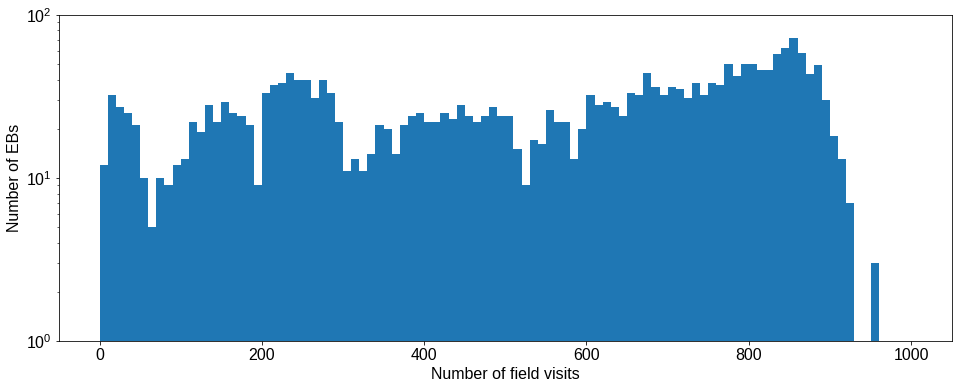

In [18]:
plt.yscale('log')
plt.ylim(1, 100)
plt.xlabel('Number of field visits')
plt.ylabel('Number of EBs')
plt.hist(counts[:,1], bins=np.linspace(0, 1000, 101))
plt.savefig(f'figures/field_visits_{opsim}.pdf');

More interestingly, we can plot the number of visits that coincide with EB eclipses:

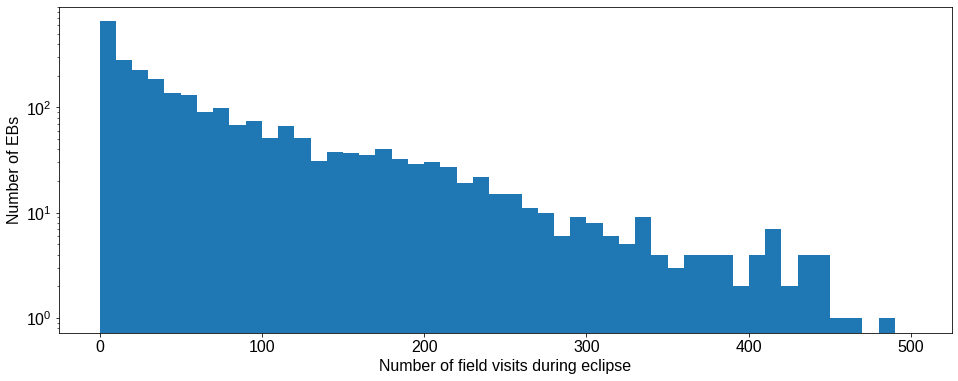

In [19]:
plt.yscale('log')
plt.xlabel('Number of field visits during eclipse')
plt.ylabel('Number of EBs')
plt.hist(counts[:,2], bins=np.linspace(0, 500, 51))
plt.savefig(f'figures/primary_eclipse_visits_{opsim}.pdf');

And even more informatively, we can plot the *fraction* of field visits during eclipse from all field visits:

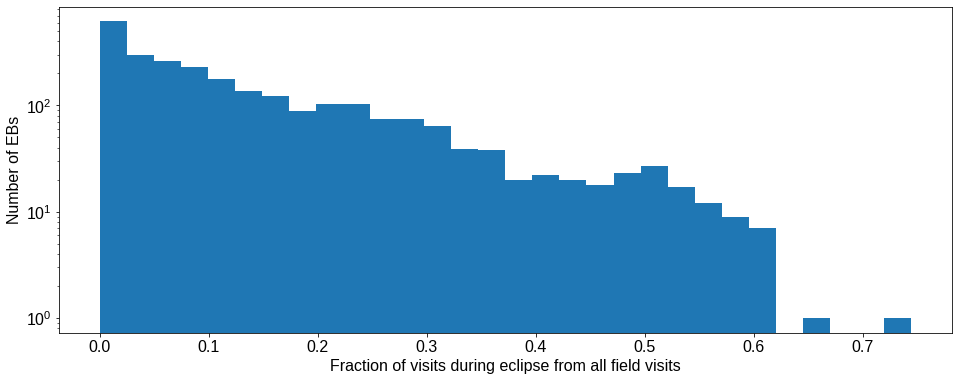

In [20]:
plt.yscale('log')
plt.xlabel('Fraction of visits during eclipse from all field visits')
plt.ylabel('Number of EBs')
plt.hist(counts[:,2]/counts[:,1], bins=30)
plt.savefig(f'figures/fraction_of_visits_{opsim}.pdf');

These three plots are depicted in Fig. 3 of the paper. We can use the fraction to form a detection metric: if, say, a given fraction of points in eclipse is observed, there is a good chance that the periodicity will be detected and that the light curve will be characterized as an EB. For 5%, for example:

In [21]:
fraction = counts[:,2]/counts[:,1]
print(f'the total number of TESS systems VRO will observe: {len(fraction)}')
print(f'systems with at least 5% of points in eclipse:     {len(fraction[fraction > 0.05])}')
print(f'detection rate: {len(fraction[fraction>0.05])/len(fraction)}')

the total number of TESS systems VRO will observe: 2602
systems with at least 5% of points in eclipse:     1683
detection rate: 0.6468101460415066


This will inevitably be a function of orbital period; let's plot that:

fraction detected: 0.6468101460415066


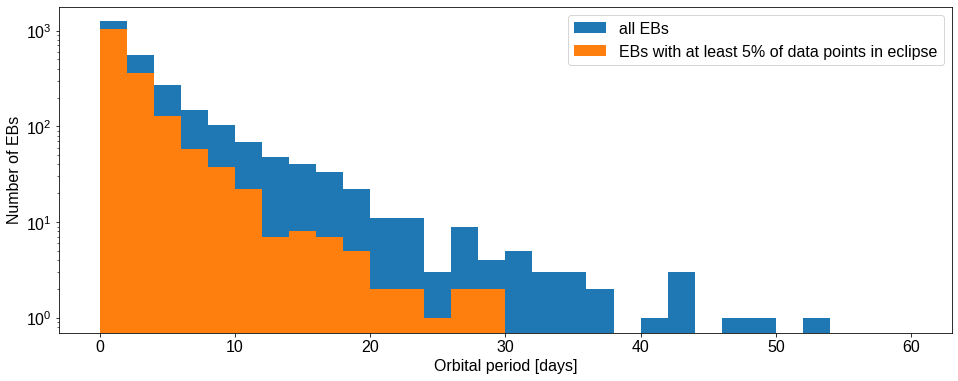

In [22]:
all_vro_periods = np.array([periods[int(tic)] for tic in counts[:,0]])
det_vro_periods = all_vro_periods[fraction>0.05]
print(f'fraction detected: {len(det_vro_periods)/len(all_vro_periods)}')

plt.yscale('log')
plt.xlabel('Orbital period [days]')
plt.ylabel('Number of EBs')
v, r, _ = plt.hist(all_vro_periods, bins=np.linspace(0, 60, 31), label='all EBs')
plt.hist(det_vro_periods, bins=r, label='EBs with at least 5% of data points in eclipse')
plt.legend()
plt.savefig(f'figures/threshold_effect_on_periods_{opsim}.pdf')

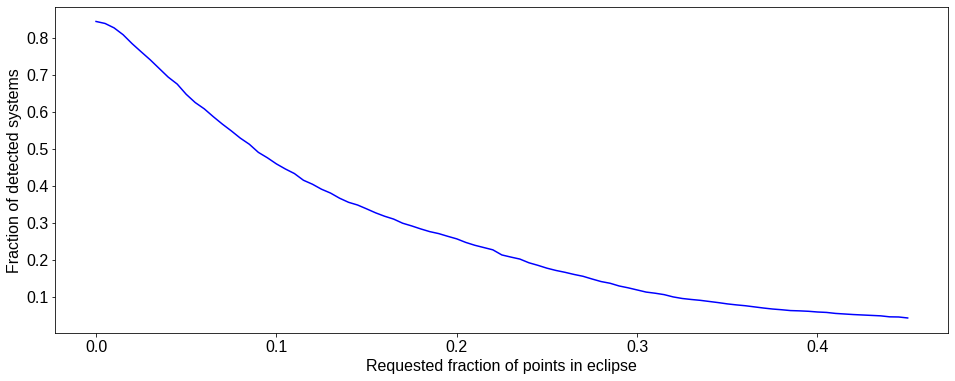

In [23]:
fractions = np.arange(0.0, 0.451, 0.005)
detected = []
for f in fractions:
    detected.append(len(all_vro_periods[fraction>f])/len(all_vro_periods))

plt.xlabel('Requested fraction of points in eclipse')
plt.ylabel('Fraction of detected systems')
plt.plot(fractions, detected, 'b-')
plt.savefig(f'figures/thresholds_{opsim}.pdf')

Note: the reason why the fraction of detected systems at the requested fraction 0 isn't 1 is because of the '>' instead of '>=' sign; but if there are 0 points in eclipse then we won't detect it as an EB no matter what. Thus, we're losing 15% of the TESS systems because LSST will never hit any of the eclipses. This becomes even worse for long period EBs (such as those detected by Kepler), but then again, we'll be mostly interested in short period MM pairs.

We can now quantify detection rates under this metric for 2.5%, 5% and 10% (Table 1 in the paper):

In [24]:
print(f'the total number of TESS systems VRO will observe: {len(fraction)}')
for threshold in [0.025, 0.05, 0.1]:
    print(f'systems with at least {threshold*100:1.1f}% of points in eclipse: {len(fraction[fraction > threshold])} ({len(fraction[fraction>threshold])/len(fraction):3.3f})')

the total number of TESS systems VRO will observe: 2602
systems with at least 2.5% of points in eclipse: 1982 (0.762)
systems with at least 5.0% of points in eclipse: 1683 (0.647)
systems with at least 10.0% of points in eclipse: 1194 (0.459)


### Interesting cases for field visit demonstration.

We have seen above that the distribution of visits per target varies quite substantially. It is useful to provide a figure to "guide the eye" on how this impacts light curve coverage (Fig. 2 in the paper):

In [26]:
tics = [399253092, 419744996, 124604724, 152507230]
lens = [len(eb_vro_obs[tic]) for tic in tics]

Generate the figures for all TICs:

In [27]:
for tic, l in zip(tics, lens):
    if l == 0:
        continue
    data = np.loadtxt(f'tess_lcs/tic{tic:010d}.01.norm.lc')
    data = data[np.argsort(data[:,1])]
    all_xs = all_phases[tic]
    all_ys = np.interp(all_xs, data[:,1], data[:,2])
    plt.title(f'TIC {tic}, P={periods[tic]:3.3f}-d, {l} observations in all filters over 10 years')
    plt.xlabel('Phase')
    plt.ylabel('Normalized flux')
    plt.plot(data[:,1], data[:,2], 'b,', label='TESS')
    plt.plot(all_xs, all_ys, 'r.', label='LSST, all filters')
    plt.savefig(f'figures/tic{tic:010d}.pdf')
    plt.clf()

<Figure size 1152x432 with 0 Axes>

### Deep drilling fields.

It is interesting to take a closer look at the number of visits in deep drilling fields. This part didn't make the cut for the paper but it still might be informative.

In [28]:
tics = dd_ebs
lens = [len(eb_vro_obs[tic]) for tic in tics]

Take one of the most visited TICs, load the data, sort it by phase, and interpolate LSST observations:

In [29]:
tic = 144598282

data = np.loadtxt(f'tess_lcs/tic{tic:010d}.01.norm.lc')
data = data[np.argsort(data[:,1])]

all_xs = all_phases[tic]
all_ys = np.interp(all_xs, data[:,1], data[:,2])

Compare TESS and simulated LSST observations:

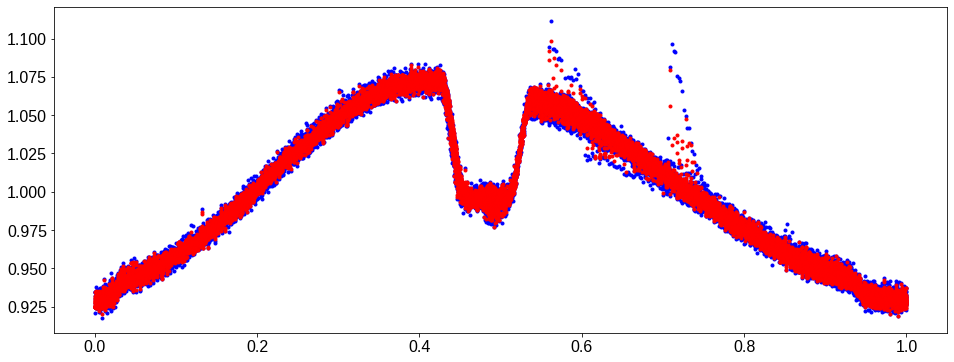

In [30]:
plt.plot(data[:,1], data[:,2], 'b.')
plt.plot(all_xs, all_ys, 'r.')

Quantify this in numbers rather than a plot:

In [31]:
ts, ps = {}, {}
print(f'TIC {tic}:')
for passband in passbands:
    ts[passband] = np.array([item[0] for item in eb_vro_obs[tic] if item[1] == passband])
    print(f'  {len(ts[passband])} timestamps in {passband}')
    ps[passband] = (ts[passband]-t0s[tic]) % periods[tic] / periods[tic]

TIC 144598282:
  1176 timestamps in u
  2325 timestamps in g
  4681 timestamps in r
  4709 timestamps in i
  2363 timestamps in z
  4679 timestamps in y


Per passband distribution of field visits:

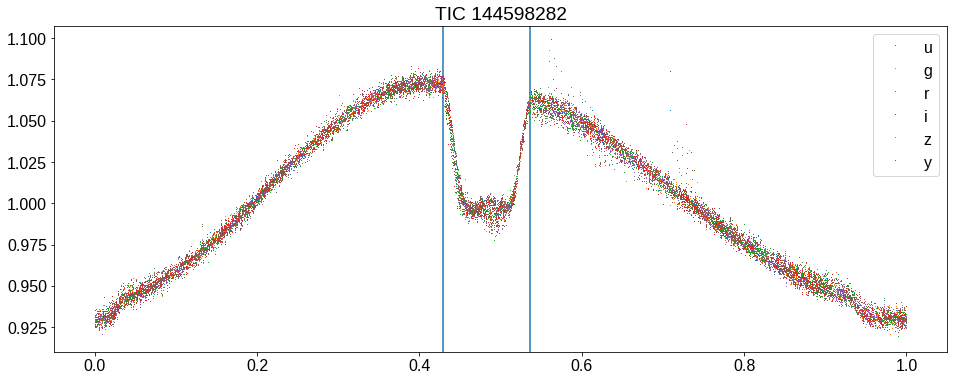

In [32]:
plt.axvline(0.483-pwidths_pf[tic]/2)
plt.axvline(0.483+pwidths_pf[tic]/2)
plt.title(f'TIC {tic}')
for passband in passbands:
    xs = ps[passband]
    ys = np.interp(xs, data[:,1], data[:,2])
    plt.plot(xs, ys, ',', label=passband)
plt.legend()

In [39]:
color = ['purple', 'red', 'orange', 'yellow', 'green', 'blue']

for tic in tics.astype(int):
    ts, ps = {}, {}
    print(f'Plotting a phased curve for TIC {tic}.')
    for passband in passbands:
        ts[passband] = np.array([item[0] for item in eb_vro_obs[tic] if item[1] == passband])
        ps[passband] = (ts[passband]-t0s[tic]) % periods[tic] / periods[tic]

    data = np.loadtxt(f'tess_lcs/tic{tic:010d}.01.norm.lc')
    data = data[np.argsort(data[:,1])]

    plt.title(f'TIC {tic}: P={periods[tic]:3.3f}-d, {len(eb_vro_obs[tic])} datapoints')
    plt.xlabel('Phase')
    plt.ylabel('Normalized flux')
    for i, passband in enumerate(passbands):
        xs = ps[passband]
        ys = i*0.03 + np.interp(xs, data[:,1], data[:,2])
        plt.plot(xs, ys, '.', c=color[i], label=passband)
        plt.plot(1+xs[xs<0.1], ys[xs<0.1], '.', c=color[i])
        plt.plot(xs[xs>0.9]-1, ys[xs>0.9], '.', c=color[i])
    plt.legend()
    plt.savefig(f'figures/tic{tic:010.0f}.pdf')
    plt.clf()

Plotting a phased curve for TIC 143022688.
Plotting a phased curve for TIC 144598282.
Plotting a phased curve for TIC 152507230.
Plotting a phased curve for TIC 219222201.
Plotting a phased curve for TIC 219238496.
Plotting a phased curve for TIC 332910947.
Plotting a phased curve for TIC 332910986.


<Figure size 1152x432 with 0 Axes>

## Comparison with other opsim runs

The logic and computation steps here are identical to the ones above, that is why we will concatenate all into a single cell. Here we loop over all opsim runs and calculate all relevant quantities that are reported in the paper.

In [40]:
subdir = 'opsims'
opsims = ['baseline_v2.1', 'galplane_priority_blue_agg_level1.5_v2.2', 'noroll_v2.2', 'draft_connected_v2.99', 'dd6_v2.99', 'low_gp_v2.99', 'roll_early_v2.99', 'draft2_rw0.9_v2.99', 'draft2_rw0.9_uz_v2.99', 'baseline_v3.0']

In [41]:
passbands = ['u', 'g', 'r', 'i', 'z', 'y']
dd_ebs = sorted(counts[:,0][counts[:,1] > 1500])

table1 = pd.DataFrame(index=opsims, columns=['Number of visits', 'Percent of baseline', '2.5% threshold', '5% threshold', '10% threshold'])
table2 = pd.DataFrame(index=opsims, columns=dd_ebs)
table3 = pd.DataFrame(index=opsims, columns=passbands)

for opsim in opsims:
    t1_row, t2_row, t3_row = [], [], []

    print(f'opsim: {opsim}:')

    # connect to the opsim:
    db = sql.connect(f'{subdir}/{opsim}_10yrs.db')
    dbc = db.cursor()
    
    # count the number of entries; no need to plot the distributions.
    dbc.execute('select fieldRa, fieldDec from observations')
    results = dbc.fetchall()
    r = np.array(results)
    numobs = r.shape[0]
    print(f'  {numobs} total field visits.')

    # check if we have precomputed timestamps; if so, load them; if not, compute and save them (time-consuming!):
    if os.path.exists(f'timestamps/timestamps_{opsim}.pkl'):
        with open(f'timestamps/timestamps_{opsim}.pkl', 'rb') as f:
            eb_vro_obs = pickle.load(f)
    else:
        print(f'  * extracting timestamps for opsim {opsim}; this takes a long time...')
        eb_vro_obs = {}
        for i, eb in enumerate(tessEBs):
            dbc.execute(f"select observationStartMJD,filter from observations where pow(fieldRa-({eb[3]}), 2) + pow(fieldDec-({eb[4]}), 2) < 3.0625")
            eb_vro_obs[int(eb[0])] = dbc.fetchall()

        with open(f'timestamps/timestamps_{opsim}.pkl', 'wb') as f:
            pickle.dump(eb_vro_obs, f)

    # passband counts:
    per_band_timestamps = {}
    for tic, timestamps in eb_vro_obs.items():
        # skip any TESS EBs that LSST will not observe:
        if len(timestamps) == 0:
            continue
        per_band_timestamps[tic] = {}
        for passband in passbands:
            per_band_timestamps[tic][passband] = [ts[0] for ts in timestamps if ts[1] == passband]

    per_band_nobs = np.empty((len(per_band_timestamps), 1+len(passbands)), dtype=int)
    i = 0
    for tic in eb_vro_obs.keys():
        if tic not in per_band_timestamps.keys():
            continue
        per_band_nobs[i,:-1] = [len(per_band_timestamps[tic][passband]) for passband in passbands]
        per_band_nobs[i, -1] = per_band_nobs[i,:-1].sum()
        i += 1
    np.savetxt(f'colors/colors_{opsim}.csv', per_band_nobs, delimiter=',', fmt='%d')

    if opsim == opsims[0]:
        # this is the baseline, we need it for reference:
        ref_nobs = per_band_nobs[:,-1].sum()
    
    t1_row += [per_band_nobs[:,-1].sum(), per_band_nobs[:,-1].sum()/ref_nobs]
    print(f'  {per_band_nobs[:,-1].sum()} total EB field visits.')
    print(f'  fraction of baseline: {per_band_nobs[:,-1].sum()/1433489:3.3f}')

    for i, pb in enumerate(passbands):
        print(f'  fraction in {pb}-band: {np.mean(per_band_nobs[:,i])/np.mean(per_band_nobs[:,-1]):0.3f} +/- {np.std(per_band_nobs[:,i])/np.mean(per_band_nobs[:,-1]):0.3f}')
        t3_row.append(f'{np.mean(per_band_nobs[:,i])/np.mean(per_band_nobs[:,-1]):0.3f} +/- {np.std(per_band_nobs[:,i])/np.mean(per_band_nobs[:,-1]):0.3f}')
    # phase up the data:
    all_times, all_phases = {}, {}
    for tic, item in eb_vro_obs.items():
        # skip any entries without ephemerides:
        if tic not in t0s.keys() or np.isnan(periods[tic]) or np.isnan(t0s[tic]):
            continue

        all_times[tic] = np.array([entry[0] for entry in item])
        all_phases[tic] = (all_times[tic]-t0s[tic]) % periods[tic] / periods[tic]

    print(f'  * {len(all_phases)} of {len(eb_vro_obs)} timeseries converted to phase series.')

    # count eclipse visits:
    counts = []
    for tic, item in eb_vro_obs.items():
        # skip any entries without ephemerides:
        if tic not in t0s.keys() or np.isnan(periods[tic]) or np.isnan(t0s[tic]) or len(item) == 0:
            continue

        timestamps, phases, eclpts = {}, {}, {}
        for passband in passbands:
            timestamps[passband] = np.array([ts[0] for ts in item if ts[1] == passband])
            phases[passband] = (timestamps[passband]-t0s[tic]) % periods[tic] / periods[tic]
            eclpts[passband] = [ph for ph in phases[passband] if in_eclipse(ph, ppos_pf[tic], pwidths_pf[tic], spos_pf[tic], swidths_pf[tic])]

        counts.append([
            tic,
            len(all_phases[tic]),
            len(eclpts['u'])+len(eclpts['g'])+len(eclpts['r'])+len(eclpts['i'])+len(eclpts['z'])+len(eclpts['y']),
            len(eclpts['u']),
            len(eclpts['g']),
            len(eclpts['r']),
            len(eclpts['i']),
            len(eclpts['z']),
            len(eclpts['y'])
        ])

    counts = np.array(counts)
    np.savetxt(f'counts/counts_{opsim}.csv', counts, delimiter=',', fmt='%d')
    
    # report fractions for Table 1:
    fraction = counts[:,2]/counts[:,1]
    print(f'  the total number of TESS systems VRO will observe: {len(fraction)}')
    for threshold in [0.025, 0.05, 0.1]:
        print(f'    systems with at least {threshold*100:1.1f}% of points in eclipse: {len(fraction[fraction > threshold])} ({len(fraction[fraction>threshold])/len(fraction):3.3f})')
        t1_row.append(len(fraction[fraction>threshold])/len(fraction))

    # deep drilling number of visits:
    dd_ebs = sorted(counts[:,0][counts[:,1] > 1500])
    
    print(f'  Deep drilling EBs: {dd_ebs}')
    for dd_eb in dd_ebs:
        print(f'    {counts[:,0][counts[:,0]==dd_eb][0]}: {counts[:,1][counts[:,0]==dd_eb][0]:5d} observations.')
        table2.loc[opsim][dd_eb] = counts[:,1][counts[:,0]==dd_eb][0]
    
    table1.loc[opsim] = t1_row
    table3.loc[opsim] = t3_row
    print('')

opsim: baseline_v2.1:
  2081749 total field visits.
  1435192 total EB field visits.
  fraction of baseline: 1.001
  fraction in u-band: 0.066 +/- 0.065
  fraction in g-band: 0.098 +/- 0.114
  fraction in r-band: 0.223 +/- 0.239
  fraction in i-band: 0.226 +/- 0.240
  fraction in z-band: 0.193 +/- 0.140
  fraction in y-band: 0.194 +/- 0.240
  * 4571 of 4578 timeseries converted to phase series.
  the total number of TESS systems VRO will observe: 2602
    systems with at least 2.5% of points in eclipse: 1982 (0.762)
    systems with at least 5.0% of points in eclipse: 1683 (0.647)
    systems with at least 10.0% of points in eclipse: 1194 (0.459)
  Deep drilling EBs: [143022688, 144598282, 152507230, 219222201, 219238496, 332910947, 332910986]
    143022688:  2189 observations.
    144598282: 19933 observations.
    152507230:  6973 observations.
    219222201:  8732 observations.
    219238496:  6309 observations.
    332910947:  9954 observations.
    332910986:  5877 observations.



In [42]:
table1.style.format(precision=3, thousands=',')

,Number of visits,Percent of baseline,2.5% threshold,5% threshold,10% threshold
baseline_v2.1,1435192,1.000,0.762,0.647,0.459
galplane_priority_blue_agg_level1.5_v2.2,1431594,0.997,0.770,0.654,0.463
noroll_v2.2,1422777,0.991,0.762,0.651,0.463
draft_connected_v2.99,1413395,0.985,0.763,0.649,0.456
dd6_v2.99,1435042,1.000,0.769,0.650,0.456
low_gp_v2.99,1426154,0.994,0.765,0.652,0.458
roll_early_v2.99,1414883,0.986,0.767,0.656,0.463
draft2_rw0.9_v2.99,1426715,0.994,0.764,0.653,0.455
draft2_rw0.9_uz_v2.99,1432166,0.998,0.767,0.658,0.464
baseline_v3.0,1432166,0.998,0.767,0.658,0.464


In [43]:
table2

,143022688,144598282,152507230,219222201,219238496,332910947,332910986
baseline_v2.1,2189,19933,6973,8732,6309,9954,5877
galplane_priority_blue_agg_level1.5_v2.2,2454,21212,7791,9811,7106,10000,5388
noroll_v2.2,2459,21250,7766,9781,7072,10014,5427
draft_connected_v2.99,2184,24355,9432,11055,8461,11849,7329
dd6_v2.99,1685,21088,7831,10270,7357,10899,6566
low_gp_v2.99,2277,24397,9450,11072,8505,11869,7337
roll_early_v2.99,2216,24364,9457,11058,8527,11835,7318
draft2_rw0.9_v2.99,2440,25407,9916,11604,8817,12261,7485
draft2_rw0.9_uz_v2.99,2182,23562,9097,10691,8065,11471,7112
baseline_v3.0,2182,23562,9097,10691,8065,11471,7112


In [44]:
table3

,u,g,r,i,z,y
baseline_v2.1,0.066 +/- 0.065,0.098 +/- 0.114,0.223 +/- 0.239,0.226 +/- 0.240,0.193 +/- 0.140,0.194 +/- 0.240
galplane_priority_blue_agg_level1.5_v2.2,0.063 +/- 0.050,0.095 +/- 0.113,0.220 +/- 0.238,0.227 +/- 0.240,0.196 +/- 0.202,0.199 +/- 0.239
noroll_v2.2,0.060 +/- 0.051,0.096 +/- 0.115,0.222 +/- 0.240,0.228 +/- 0.243,0.199 +/- 0.203,0.195 +/- 0.242
draft_connected_v2.99,0.058 +/- 0.056,0.088 +/- 0.133,0.228 +/- 0.274,0.232 +/- 0.276,0.196 +/- 0.224,0.199 +/- 0.273
dd6_v2.99,0.057 +/- 0.049,0.088 +/- 0.116,0.228 +/- 0.242,0.233 +/- 0.243,0.197 +/- 0.202,0.198 +/- 0.239
low_gp_v2.99,0.058 +/- 0.056,0.088 +/- 0.133,0.226 +/- 0.274,0.231 +/- 0.276,0.196 +/- 0.225,0.200 +/- 0.273
roll_early_v2.99,0.057 +/- 0.056,0.088 +/- 0.133,0.227 +/- 0.274,0.233 +/- 0.276,0.196 +/- 0.224,0.199 +/- 0.272
draft2_rw0.9_v2.99,0.055 +/- 0.055,0.088 +/- 0.131,0.227 +/- 0.273,0.233 +/- 0.275,0.201 +/- 0.300,0.196 +/- 0.242
draft2_rw0.9_uz_v2.99,0.056 +/- 0.055,0.089 +/- 0.131,0.229 +/- 0.273,0.235 +/- 0.274,0.195 +/- 0.208,0.196 +/- 0.247
baseline_v3.0,0.056 +/- 0.055,0.089 +/- 0.131,0.229 +/- 0.273,0.235 +/- 0.274,0.195 +/- 0.208,0.196 +/- 0.247


Print out the results into latex-compatible tables to be included in the paper:

In [45]:
print(table1.to_latex(
    formatters={'Number of visits': lambda x: f'{x:,}'},
    float_format=lambda x: f'{x:3.3f}',
    column_format='lccccc',
    caption='Comparison of the studied opsim runs w.r.t.~the EB classification efficiency. The duty cycle of all opsim runs is within 1.5\%. The detection threshold defines the lower integration boundary of the cumulative distribution of EBs. The main takeaway is that all opsim runs are roughly equivalent in the EB yield.',
    label='tab:comparison',
    position='t!',
    bold_rows=False
))

\begin{table}[t!]
\centering
\caption{Comparison of the studied opsim runs w.r.t.~the EB classification efficiency. The duty cycle of all opsim runs is within 1.5\%. The detection threshold defines the lower integration boundary of the cumulative distribution of EBs. The main takeaway is that all opsim runs are roughly equivalent in the EB yield.}
\label{tab:comparison}
\begin{tabular}{lccccc}
\toprule
{} & Number of visits & Percent of baseline & 2.5\% threshold & 5\% threshold & 10\% threshold \\
\midrule
baseline\_v2.1                            &        1,435,192 &               1.000 &          0.762 &        0.647 &         0.459 \\
galplane\_priority\_blue\_agg\_level1.5\_v2.2 &        1,431,594 &               0.997 &          0.770 &        0.654 &         0.463 \\
noroll\_v2.2                              &        1,422,777 &               0.991 &          0.762 &        0.651 &         0.463 \\
draft\_connected\_v2.99                    &        1,413,395 &               0.9

In [46]:
print(table2.to_latex(
    column_format='lccccccc',
    caption='\\textsl{TESS} EB targets that land in one of the deep drilling fields, and the number of visits for the respective opsims.',
    label='tab:ddf',
    position='t!',
    bold_rows=False
))

\begin{table}[t!]
\centering
\caption{\textsl{TESS} EB targets that land in one of the deep drilling fields, and the number of visits for the respective opsims.}
\label{tab:ddf}
\begin{tabular}{lccccccc}
\toprule
{} & 143022688 & 144598282 & 152507230 & 219222201 & 219238496 & 332910947 & 332910986 \\
\midrule
baseline\_v2.1                            &      2189 &     19933 &      6973 &      8732 &      6309 &      9954 &      5877 \\
galplane\_priority\_blue\_agg\_level1.5\_v2.2 &      2454 &     21212 &      7791 &      9811 &      7106 &     10000 &      5388 \\
noroll\_v2.2                              &      2459 &     21250 &      7766 &      9781 &      7072 &     10014 &      5427 \\
draft\_connected\_v2.99                    &      2184 &     24355 &      9432 &     11055 &      8461 &     11849 &      7329 \\
dd6\_v2.99                                &      1685 &     21088 &      7831 &     10270 &      7357 &     10899 &      6566 \\
low\_gp\_v2.99                        

In [47]:
def asc2tex(x):
    return '$' + x.replace('+/-', '\pm') + '$'

print(table3.to_latex(
    formatters={'u': asc2tex, 'g': asc2tex, 'r': asc2tex, 'i': asc2tex, 'z': asc2tex, 'y': asc2tex},
    float_format=lambda x: f'{x:3.3f}',
    column_format='lcccccc',
    caption='The fraction of visits in each passband, averaged over all targets. The distribution is clearly not gaussian (cf.~Fig.~\\ref\{fig:colors\}), but we still provide standard deviation as a rough dispersion estimate. These values should thus only be regarded as an order of magnitude estimates.',
    label='tab:colors',
    position='t!',
    bold_rows=False,
    escape=False
))

\begin{table}[t!]
\centering
\caption{The fraction of visits in each passband, averaged over all targets. The distribution is clearly not gaussian (cf.~Fig.~\ref\{fig:colors\}), but we still provide standard deviation as a rough dispersion estimate. These values should thus only be regarded as an order of magnitude estimates.}
\label{tab:colors}
\begin{tabular}{lcccccc}
\toprule
{} &                  u &                  g &                  r &                  i &                  z &                  y \\
\midrule
baseline_v2.1                            &  $0.066 \pm 0.065$ &  $0.098 \pm 0.114$ &  $0.223 \pm 0.239$ &  $0.226 \pm 0.240$ &  $0.193 \pm 0.140$ &  $0.194 \pm 0.240$ \\
galplane_priority_blue_agg_level1.5_v2.2 &  $0.063 \pm 0.050$ &  $0.095 \pm 0.113$ &  $0.220 \pm 0.238$ &  $0.227 \pm 0.240$ &  $0.196 \pm 0.202$ &  $0.199 \pm 0.239$ \\
noroll_v2.2                              &  $0.060 \pm 0.051$ &  $0.096 \pm 0.115$ &  $0.222 \pm 0.240$ &  $0.228 \pm 0.243$ &  $0.199 \p

That concludes the calculations! The results are reported in the paper. For any comments, suggestions or corrections, please reach out to me at [aprsa@villanova.edu](mailto:aprsa@villanova.edu).